In [29]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from pandas import concat
from math import sqrt

In [97]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

In [67]:
import seaborn as sns
sns.set_style("whitegrid")

In [68]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
col_names= ["date", "values"]

In [71]:
data = pd.read_csv("Electric_Production.csv", names = col_names, header = 0, parse_dates = [0])

In [72]:
data.head()

,date,values
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [73]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format= True)
data = data.set_index(['date'])

In [74]:
data.head(10)

,values
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
1985-06-01,58.0904
1985-07-01,62.6202
1985-08-01,63.2485
1985-09-01,60.5846


In [75]:
rolling_mean= data.rolling(window=12).mean()

In [76]:
rolling_std = data.rolling(window= 12).std()

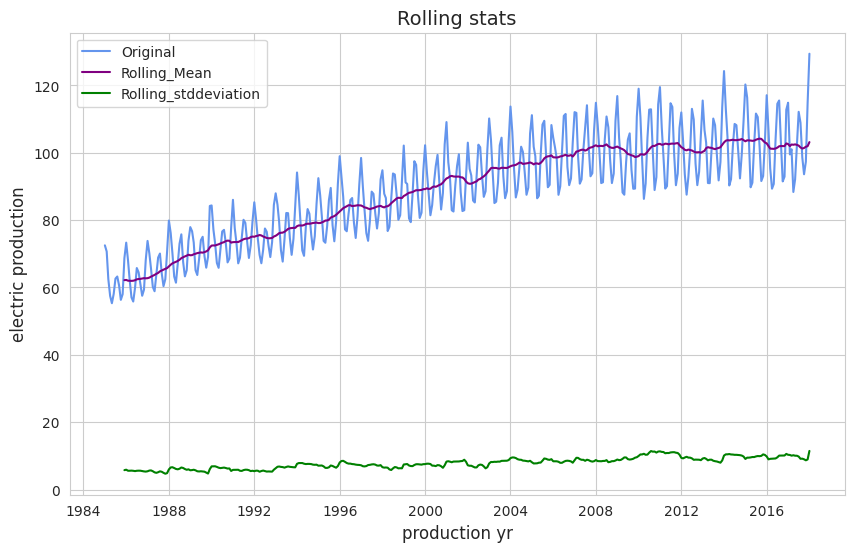

In [77]:
plt.figure(figsize= (10,6))
plt.plot(data, color = "cornflowerblue", label= 'Original')
plt.plot(rolling_mean, color= "purple",label= "Rolling_Mean")
plt.plot(rolling_std, color= "green",label = "Rolling_stddeviation")
plt.xlabel('production yr', size =12)
plt.ylabel('electric production', size= 12)
plt.legend(loc = 'upper left')
plt.title('Rolling stats', size = 14)
plt.show()

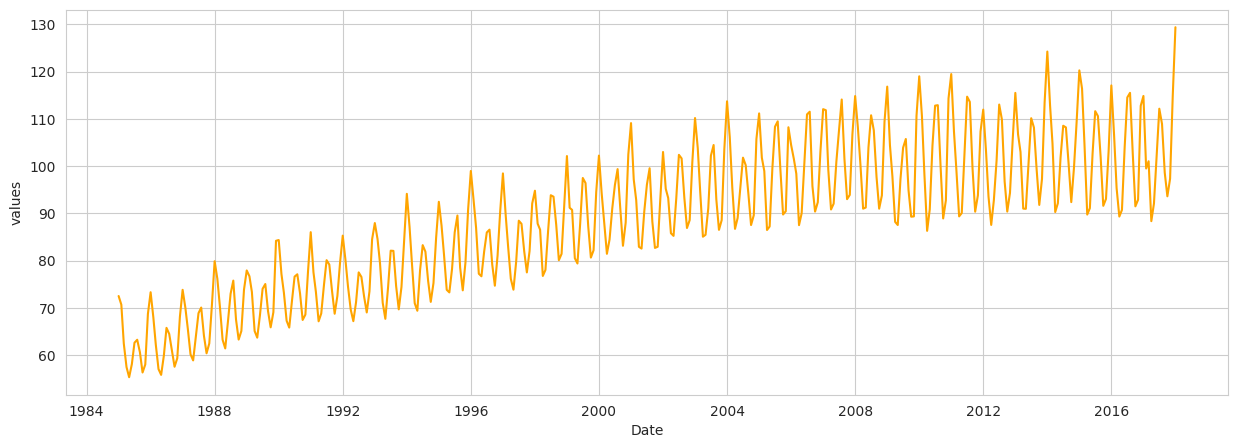

In [78]:
plt.figure(figsize=(15,5))
plt.plot(data['values'], color = "Orange")
plt.xlabel('Date', size =10)
plt.ylabel('values', size=10)
plt.show()
#data shows an upward trend

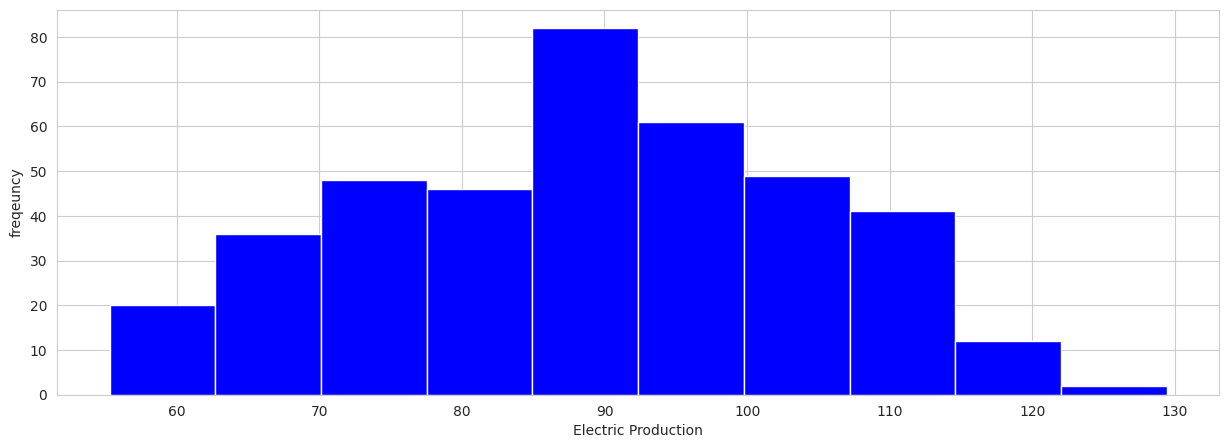

In [79]:
plt.figure(figsize=(15,5))
plt.hist(data['values'], color = "Blue")
plt.xlabel('Electric Production', size =10)
plt.ylabel('freqeuncy', size=10)
plt.show()

In [80]:
print("Data Shape {}".format(data.shape))

Data Shape (397, 1)


In [81]:
value_1 = data[0: 199]
value_2= data[200:397]
#splitting data to find mean and variance

In [82]:
print(f"Mean_1 {round(value_1.mean()[0],3)}")
print(f"Mean_2 {round(value_2.mean()[0], 3)}")

Mean_1 77.497
Mean_2 100.258


In [83]:
print(f"var_1 {round(value_1.var()[0],3)}")
print(f"var_2 {round(value_2.var()[0], 3)}")

var_1 123.226
var_2 91.677


In [84]:
def ADF(ts, window=12):
  mov_Avg = ts.rolling(window).mean()
  mov_Std = ts.rolling(window).std()

  plt.figure(figsize=(10,6))
  original = plt.plot(ts, color= "blue", label= "Original")
  Mean = plt.plot(mov_Avg , color= "green", label = "Moving Average")
  Std = plt.plot(mov_Std, color = "purple", label = "Standard deviation")
  plt.legend(loc= "upper left")
  plt.title("Rolling stats")
  plt.show(block= False)

  adf = adfuller(ts, autolag = 'AIC')
  print("")
  print(adf)
  print("")
  print('ADF Statistic: {}'.format(round(adf[0],3)))
  print('p-value: {}'.format(round(adf[1],3)))
  print("")
  print('Critical Values:')

  for key, ts in adf[4].items():
    print('{}: {}'.format(key, round(ts,3)))
    print("")

  if adf[0] > adf[4]["5%"]:
        print("p-value > 0.05")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
  else:
        print("p-value < 0.05")
        print ("Reject null hypothesis, time series is stationary.")



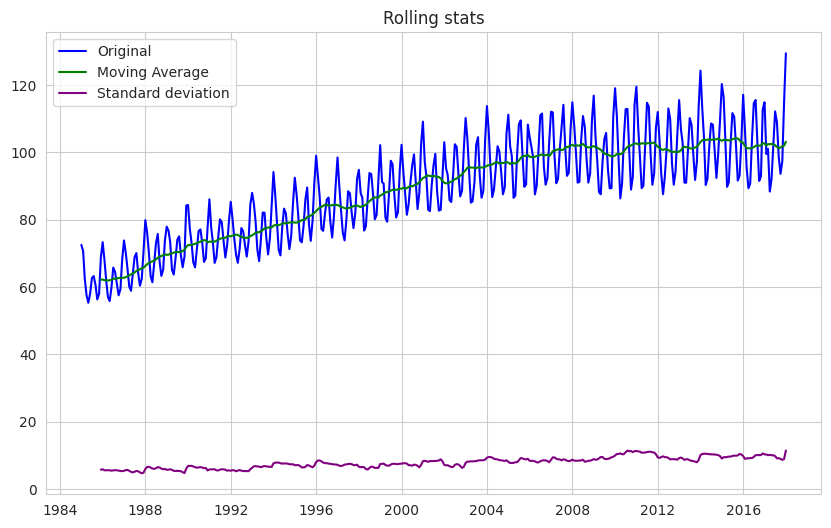


(-2.256990350047235, 0.1862146911658712, 15, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 1840.8474501627156)

ADF Statistic: -2.257
p-value: 0.186

Critical Values:
1%: -3.448

5%: -2.869

10%: -2.571

p-value > 0.05
Failed to reject null hypothesis, time series is non-stationary.


In [85]:
ADF(data, window=12)
#adf > critical value and P-value > .05 => non stationary => Null hypothesis accepted

In [86]:
#boxcox convertion through log
data_log_scaled = data
data_log_scaled['values'] = boxcox(data_log_scaled['values'], lmbda= 0.0)
print(data_log_scaled)

              values
date                
1985-01-01  4.283658
1985-02-01  4.258049
1985-03-01  4.134369
1985-04-01  4.051287
1985-05-01  4.013046
...              ...
2017-09-01  4.591227
2017-10-01  4.539177
2017-11-01  4.578168
2017-12-01  4.742505
2018-01-01  4.862945

[397 rows x 1 columns]


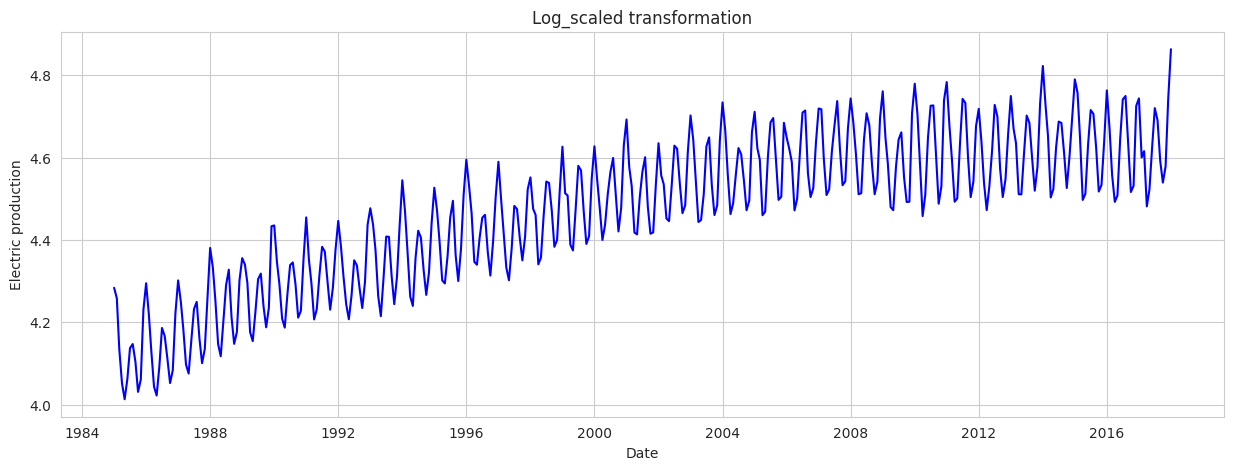

In [87]:
plt.figure(figsize=(15,5))
plt.plot(data_log_scaled['values'], color = "Blue")
plt.xlabel('Date', size =10)
plt.ylabel('Electric production', size=10)
plt.title("Log_scaled transformation")
plt.show()

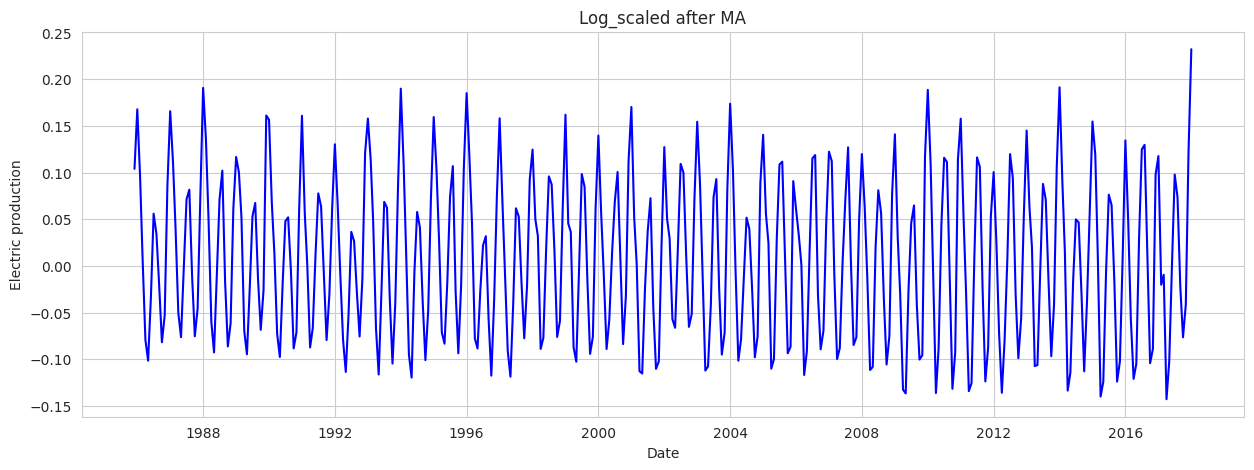

In [88]:
#removing trend stationarity
moving_avg = data_log_scaled.rolling(window=12).mean()
data_logged_ma = data_log_scaled - moving_avg
data_logged_ma.dropna(inplace= True)
plt.figure(figsize=(15,5))
plt.plot(data_logged_ma['values'], color = "Blue")
plt.xlabel('Date', size =10)
plt.ylabel('Electric production', size=10)
plt.title("Log_scaled after MA")
plt.show()

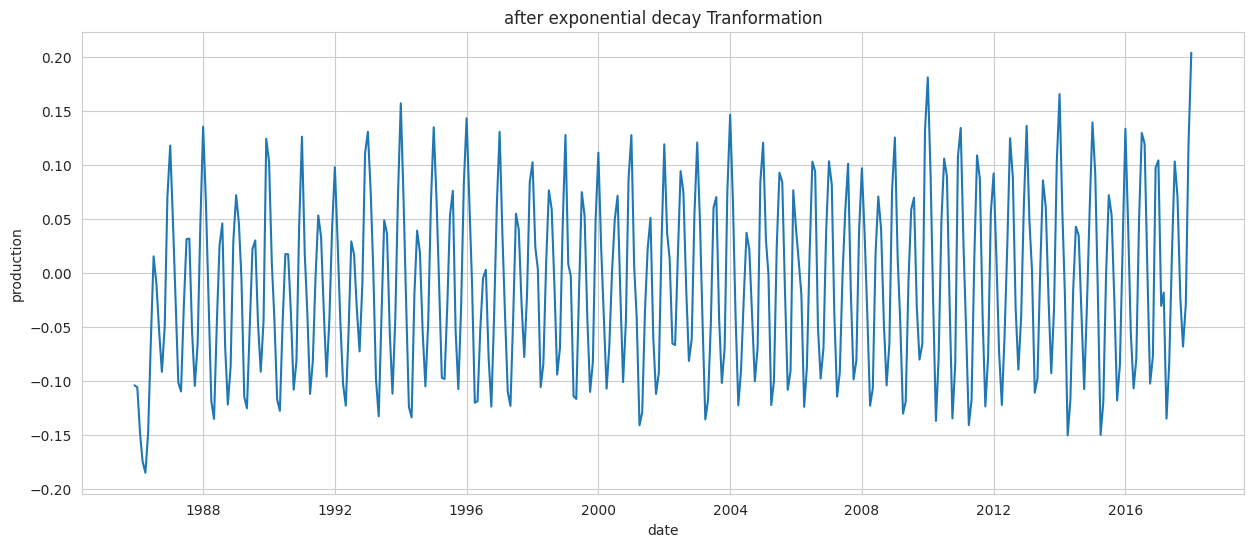

In [89]:
#exponential decay
data_expodecay = data_logged_ma.ewm(halflife = 12, min_periods=0, adjust = True).mean()
dataLogma_minus_data_expodecay = data_logged_ma - data_expodecay
plt.figure(figsize = (15,6))
plt.plot(dataLogma_minus_data_expodecay - data_expodecay)
plt.xlabel('date')
plt.ylabel('production')
plt.title("after exponential decay Tranformation")
plt.show()

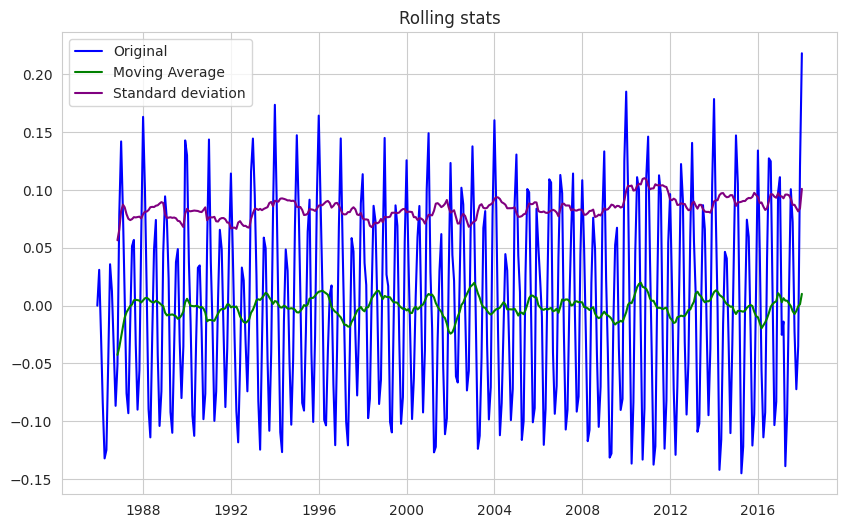


(-7.213159866628945, 2.2077706757453696e-10, 14, 371, {'1%': -3.4480996560263386, '5%': -2.8693621113224137, '10%': -2.570937038891028}, -1673.13348908759)

ADF Statistic: -7.213
p-value: 0.0

Critical Values:
1%: -3.448

5%: -2.869

10%: -2.571

p-value < 0.05
Reject null hypothesis, time series is stationary.


In [90]:
#cheching statiponarity agaion
ADF(dataLogma_minus_data_expodecay, window =12)

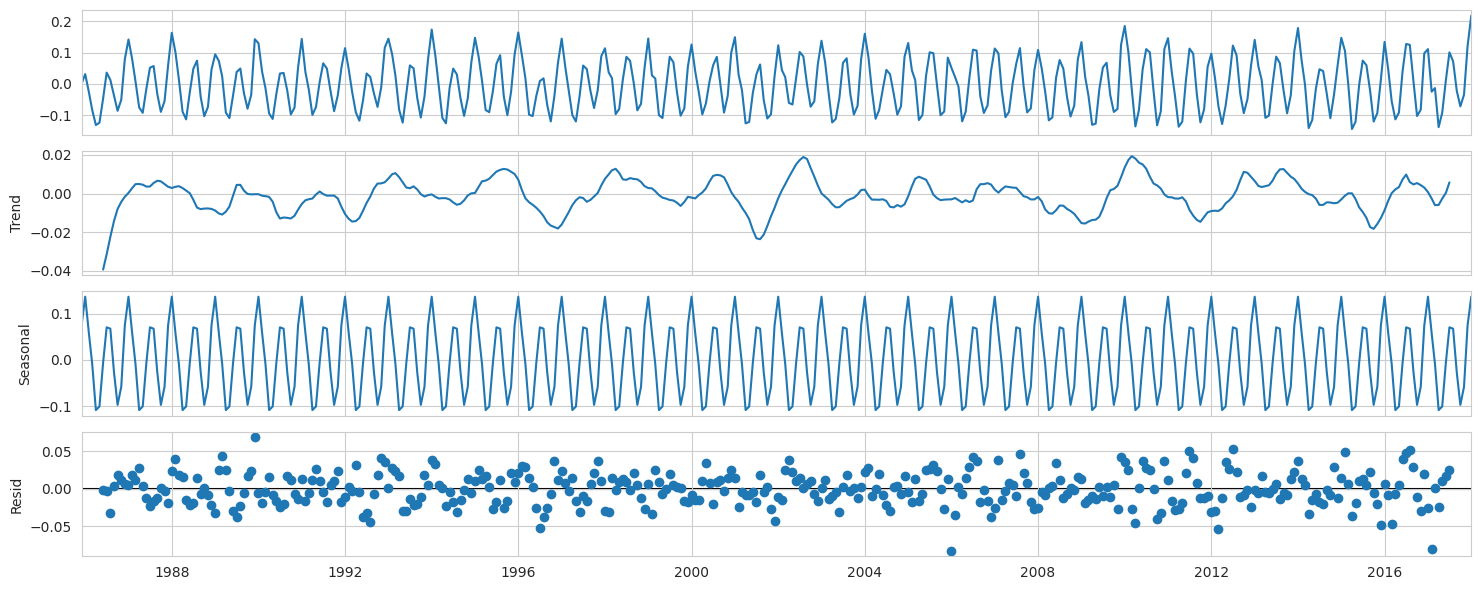

In [91]:
#seasonal decompose
rcParams['figure.figsize'] = 15, 6
data_seasonal_decompose = seasonal_decompose(dataLogma_minus_data_expodecay, model='duplicative')
data_seasonal_decompose.plot()
plt.show()

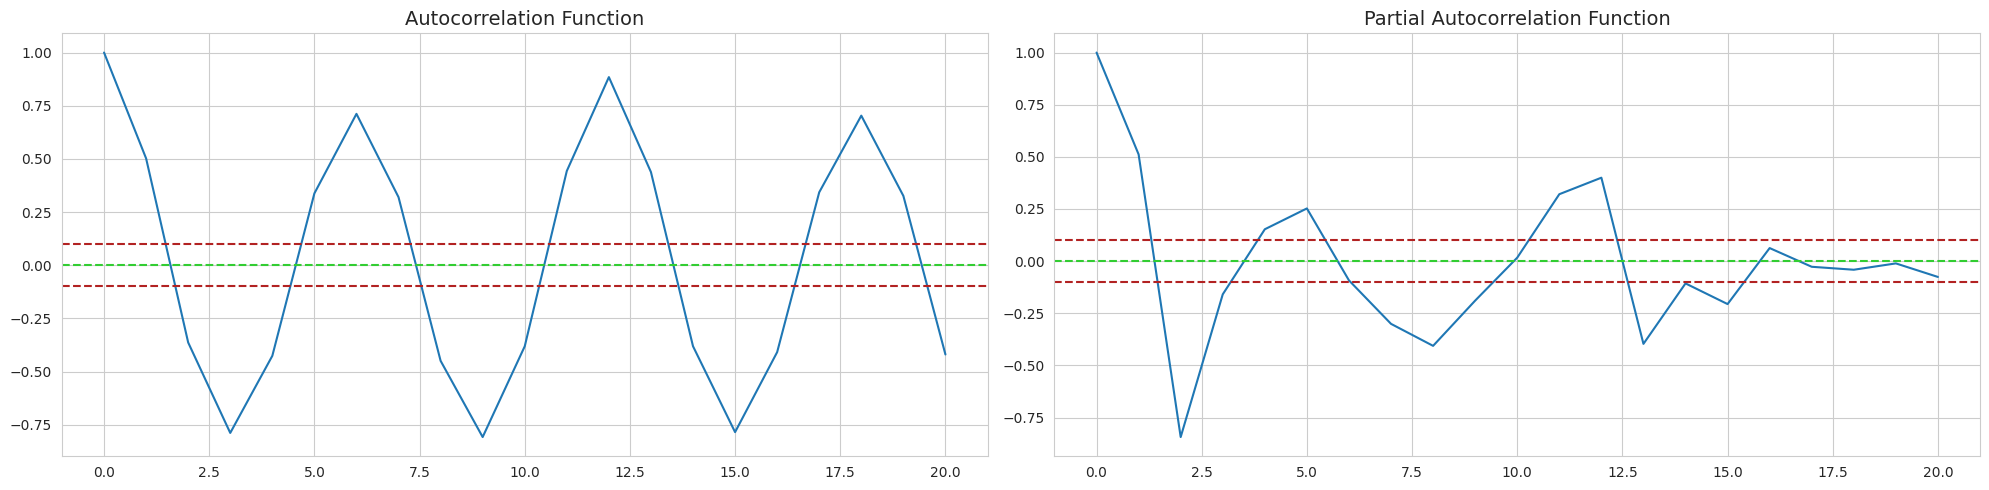

In [92]:
#ACF
ACF = acf(dataLogma_minus_data_expodecay, nlags= 20)
PACF = pacf(dataLogma_minus_data_expodecay, nlags= 20, method= "ols")
fig, axs = plt.subplots(1, 2, figsize = (20,5))

plt.subplot(121)
plt.plot(ACF)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(dataLogma_minus_data_expodecay)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(dataLogma_minus_data_expodecay)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)

plt.subplot(122)
plt.plot(PACF)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(dataLogma_minus_data_expodecay)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(dataLogma_minus_data_expodecay)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)

plt.tight_layout()

In [93]:
val = pd.DataFrame(dataLogma_minus_data_expodecay.values)
persistance_data = concat([val.shift(1),val], axis=1)
persistance_data.columns = ['t-1', 't+1']
per_data = persistance_data.values

per_values = persistance_data.values

train = per_data[1:len(per_values)-10]
test = per_data[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))


Persistence MSE: 0.0084


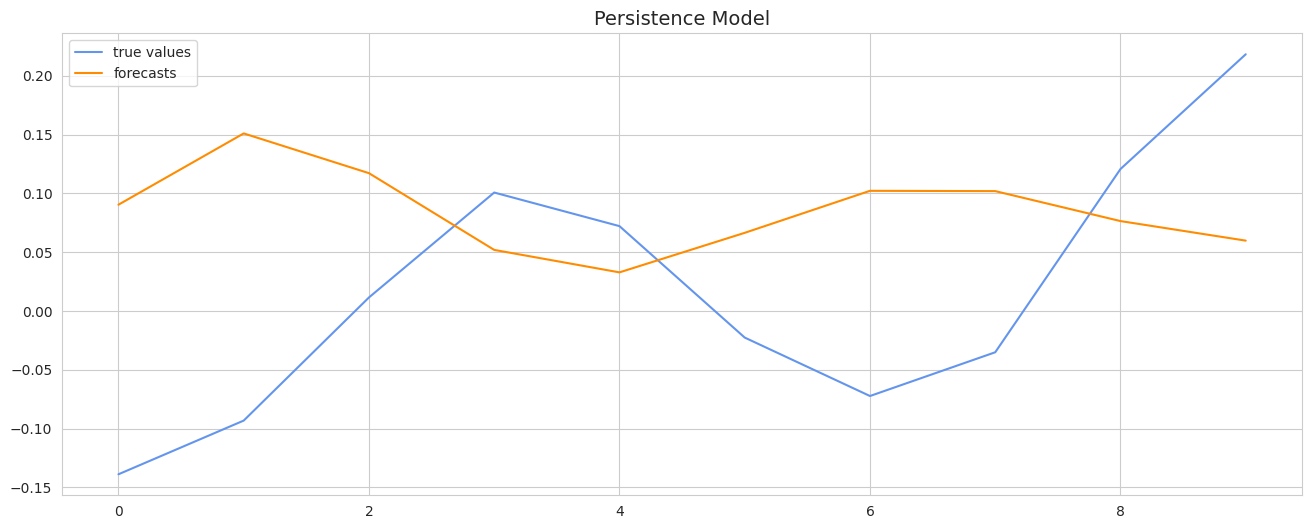

In [101]:
plt.figure(figsize = (16,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [98]:
ar_values = dataLogma_minus_data_expodecay.values
train = ar_values[1:len(ar_values)-10]
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0211


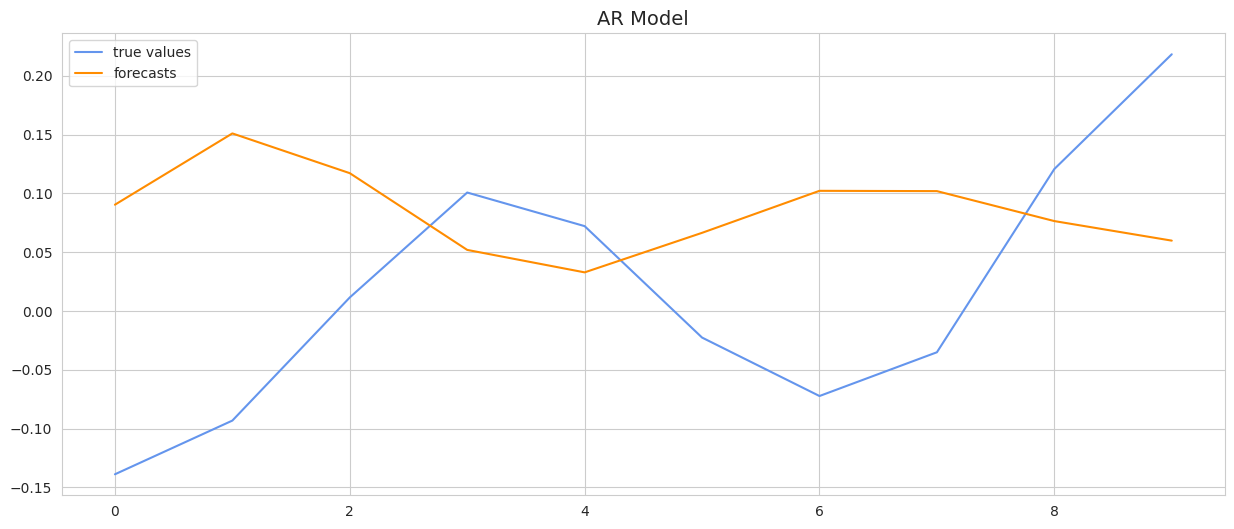

In [100]:
plt.figure(figsize = (15,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [102]:
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0117


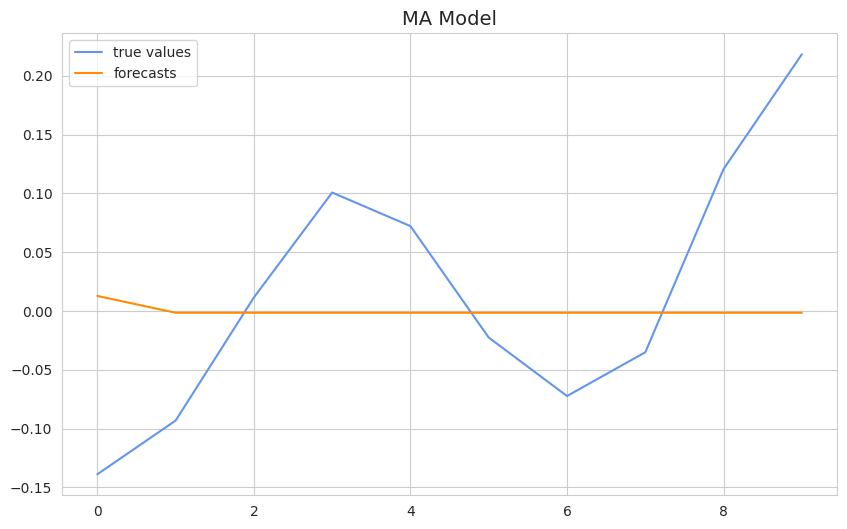

In [103]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [104]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.0019


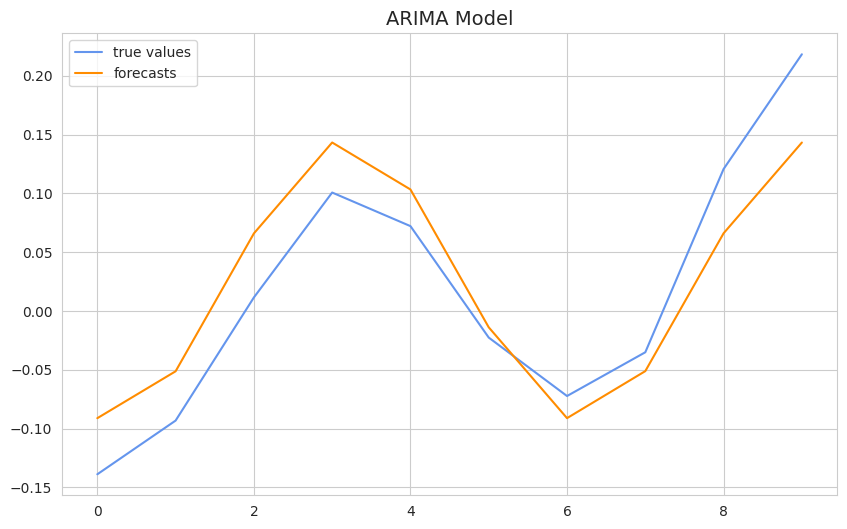

In [105]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [107]:
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Blues', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
ARIMA,0.001906
Persistence,0.008401
Moving Average,0.011716
Autoregression,0.021126
